In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

import rpy2
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
# pd.set_option("display.max_columns", None)

In [3]:
NSCLC_sc = sc.read_h5ad("./NSCLC_sc/scRNA.h5ad")


In [4]:
cosmx_sc = sc.read_h5ad("./sc_lung_5_1.h5ad")

In [5]:
# 获取两个数据集的基因名称集合
genes1 = set(NSCLC_sc.var_names)
genes2 = set(cosmx_sc.var_names)

# 获取共有基因
common_genes = genes1.intersection(genes2)

NSCLC_sc = NSCLC_sc[:, NSCLC_sc.var_names.isin(common_genes)]
cosmx_sc = cosmx_sc[:, cosmx_sc.var_names.isin(common_genes)]

In [6]:
# NSCLC_sc, cosmx_sc
cosmx_sc = cosmx_sc[:10000]

In [7]:
cosmx_sc.obs['cell_type'].value_counts(), NSCLC_sc.obs['celltype_final'].value_counts()

(tumor           2255
 endothelial     1081
 fibroblast      1071
 neutrophil       865
 T CD4 naive      702
 B-cell           688
 epithelial       662
 macrophage       610
 plasmablast      578
 mDC              339
 pDC              292
 mast             273
 T CD8 naive      230
 NK               185
 T CD4 memory      75
 monocyte          63
 Treg              24
 T CD8 memory       7
 Name: cell_type, dtype: int64,
 T_cells            2507
 Mac_Mono           2398
 Fibroblast         1603
 Plasma              634
 Endothelial         620
 DCs                 487
 Alveolar_type_2     476
 B_cells             358
 Mast                350
 Neutrophils         344
 Alveolar_type_1     115
 Club_cells           89
 Ciliated_cells       19
 Name: celltype_final, dtype: int64)

In [8]:
chosen_celltype_sc = "Plasma"
chosen_celltype_cosmx = "plasmablast"

cosmx_sc_chosen = cosmx_sc[cosmx_sc.obs['cell_type'] == chosen_celltype_cosmx]
sc_nsclc_chosen = NSCLC_sc[NSCLC_sc.obs['celltype_final'] == chosen_celltype_sc]


In [9]:
cosmx_sc_chosen, sc_nsclc_chosen

(View of AnnData object with n_obs × n_vars = 578 × 942
     obs: 'cell_ID', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors',
 View of AnnData object with n_obs × n_vars = 634 × 942
     obs: 'celltype_final'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
     uns: 'celltype_mapper', 'neighbors'
     obsm: 'X_pca', 'X_tsne'
     varm: 'PCs'
     layers: 'norm')

In [10]:
sc_nsclc_chosen.obs_names, cosmx_sc_chosen.obs_names

(Index(['K15_B001470', 'E1_B003121', 'P12_B001474', 'M5_B001474', 'K10_B001557',
        'I7_B003523', 'O19_B001474', 'D2_B003643', 'D9_B003777', 'N16_B001475',
        ...
        'H11_B001551', 'F21_B001544', 'O19_B003191', 'D6_B003654',
        'J14_B001544', 'M7_B002074', 'O6_B003771', 'G4_B001545', 'C2_B002074',
        'D16_B001557'],
       dtype='object', length=634),
 Index(['7', '15', '21', '26', '34', '35', '49', '59', '62', '63',
        ...
        '9448', '9456', '9508', '9513', '9524', '9525', '9555', '9644', '9904',
        '9961'],
       dtype='object', length=578))

In [11]:
cosmx_sc_chosen_list = ['1'] * len(cosmx_sc_chosen.obs_names) + ['0'] * len(sc_nsclc_chosen.obs_names)
sc_nsclc_chosen_list = ['0'] * len(cosmx_sc_chosen.obs_names) + ['1'] * len(sc_nsclc_chosen.obs_names)
index_list = list(cosmx_sc_chosen.obs_names) + list(sc_nsclc_chosen.obs_names)
design = pd.DataFrame({'cosmx': cosmx_sc_chosen_list, 'sc': sc_nsclc_chosen_list}, index=index_list)


In [12]:
design = design.applymap(lambda x: int(x))

In [13]:
sc_nsclc_chosen_df = pd.DataFrame(sc_nsclc_chosen.X.todense(), index=sc_nsclc_chosen.obs_names, columns=sc_nsclc_chosen.var_names)
cosmx_sc_chosen_df = pd.DataFrame(cosmx_sc_chosen.X, index=cosmx_sc_chosen.obs_names, columns=cosmx_sc_chosen.var_names)

# # 拼接两个DataFrame
exp = pd.concat([cosmx_sc_chosen_df, sc_nsclc_chosen_df], axis=0).T

In [14]:
limma = importr('limma')
edgeR = importr('edgeR')
contrast_matrix = limma.makeContrasts(
    'cosmx-sc', levels=design
)

In [15]:
exp_r = pandas2ri.py2rpy(exp)
design = pandas2ri.py2rpy(design)
from rpy2.robjects import globalenv
globalenv['exp_r']=exp_r
globalenv['design']=design
rscript='''
contrasts_matrix<-makeContrasts("cosmx-sc",levels=design)

v <- voom(exp_r,design,normalize="quantile")
fit<-lmFit(v,design)
fit2<-contrasts.fit(fit,contrasts_matrix)
fit2<-eBayes(fit2)
temp<-topTable(fit2,coef=1,n=Inf)
nrDEG=na.omit(temp)
'''
r(rscript)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
MZT2A,7.916703,11.578314,74.862483,0.000000e+00,0.000000e+00,1029.814635
DUSP5,7.003571,12.453799,59.272258,0.000000e+00,0.000000e+00,810.797166
TYK2,6.408405,10.432292,36.753948,2.035741e-199,6.392227e-197,444.840730
CALM1,-4.702233,9.172520,-20.165240,3.153156e-78,7.425683e-76,167.402709
NFKBIA,-6.171004,10.301153,-17.375876,1.437943e-60,2.709085e-58,126.976919
...,...,...,...,...,...,...
IGFBP6,0.005175,6.643062,0.031862,9.745877e-01,9.787437e-01,-7.716297
LAG3,-0.008933,6.573638,-0.068692,9.452458e-01,9.574426e-01,-7.718487
PPARD,-0.004725,6.585007,-0.033744,9.730870e-01,9.782796e-01,-7.719721
TXK,-0.000436,6.590850,-0.003047,9.975691e-01,9.975691e-01,-7.719912


In [16]:
result=r(rscript)   ##赋值给新的变量，方便后面调用
fold_cutoff=1
adjp_cutoff=0.05
 
list3=[]   #准备一个列表来装接下来差异条件遍历的结果
normal_list=[]  ##装没有显著差异的symbol ID
for j in range(0,len(result.index)):
    if (abs(result['logFC'][j])>=fold_cutoff) and (result['adj.P.Val'][j]<=adjp_cutoff):
        list3.append(j)
    else:
        normal_list.append(result.index.tolist()[j])
print("差异表达基因的数量：",len(list3))
print("差异不显著基因的数量：",len(normal_list))

差异表达基因的数量： 143
差异不显著基因的数量： 799


In [17]:
up_list=[]   # up-reguated gene id list
for h1 in range(0,len(result.index)):
    if (result['logFC'][h1]>=fold_cutoff) and (result['adj.P.Val'][h1]<=adjp_cutoff):
        up_list.append(result.index.tolist()[h1])
down_list=[]  # down-regulated gene id list
for h2 in range(0,len(result.index)):
    if (result['logFC'][h2]<-(fold_cutoff)) and (result['adj.P.Val'][h2]<=adjp_cutoff):
        down_list.append(result.index.tolist()[h2])
print("the number of up-regulated genes:",len(up_list))
print("the number of down-regulated genes",len(down_list))
print("the number of differentially expressed genes:",len(up_list)+len(down_list))
DEG_up=exp[exp.index.isin(up_list)]
DEG_down=exp[exp.index.isin(down_list)]
print("the dimsension of up-regulated genes:",DEG_up.shape)
print("the dimsension of down-regulated genes",DEG_down.shape)
DEG_up['up/down']=['up']*len(DEG_up) #添加标签
DEG_down['up/down']=['down']*len(DEG_down) #添加标签
DEG_matrix=pd.concat([DEG_up,DEG_down],join='inner')   ##合并
DEG_matrix
# DEG_matrix.to_excel("Lung.xlsx",index=True)   #保存下来

the number of up-regulated genes: 35
the number of down-regulated genes 108
the number of differentially expressed genes: 143
the dimsension of up-regulated genes: (35, 1212)
the dimsension of down-regulated genes (108, 1212)


,7,15,21,26,34,35,49,59,62,63,...,F21_B001544,O19_B003191,D6_B003654,J14_B001544,M7_B002074,O6_B003771,G4_B001545,C2_B002074,D16_B001557,up/down
BGN,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,up
C1QA,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,up
CD3E,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,up
COL1A1,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,up
COL1A2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TNFRSF17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,160.0,3.0,48.0,0.0,0.0,0.0,6.0,down
TUBB4B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,748.0,73.0,2004.0,0.0,1637.0,1945.0,593.0,550.0,1578.0,down
VIM,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,11.0,29.0,1571.0,717.0,4110.0,3966.0,1503.0,2155.0,408.0,down
XBP1,4.0,1.0,0.0,1.0,7.0,2.0,0.0,0.0,7.0,6.0,...,6196.0,212.0,1420.0,17717.0,822.0,4668.0,1754.0,325.0,5791.0,down


In [18]:
result['adj.P.Val_log']=-np.log10(result['adj.P.Val'])   #将adj.P.Val列的值全部负对数转换
result['sig']='normal'    #新设一列sig全部为normal
result.loc[(result['logFC']>=1)&(result['adj.P.Val']<0.05),'sig']='up'   #上调基因sig将normal替换为up
result.loc[(result['logFC']<-1)&(result['adj.P.Val']<0.05),'sig']='down'  ##上调基因sig将normal替换为down     
result

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
MZT2A,7.916703,11.578314,74.862483,0.000000e+00,0.000000e+00,1029.814635,inf,up
DUSP5,7.003571,12.453799,59.272258,0.000000e+00,0.000000e+00,810.797166,inf,up
TYK2,6.408405,10.432292,36.753948,2.035741e-199,6.392227e-197,444.840730,196.194348,up
CALM1,-4.702233,9.172520,-20.165240,3.153156e-78,7.425683e-76,167.402709,75.129264,down
NFKBIA,-6.171004,10.301153,-17.375876,1.437943e-60,2.709085e-58,126.976919,57.567177,down
...,...,...,...,...,...,...,...,...
IGFBP6,0.005175,6.643062,0.031862,9.745877e-01,9.787437e-01,-7.716297,0.009331,normal
LAG3,-0.008933,6.573638,-0.068692,9.452458e-01,9.574426e-01,-7.718487,0.018887,normal
PPARD,-0.004725,6.585007,-0.033744,9.730870e-01,9.782796e-01,-7.719721,0.009537,normal
TXK,-0.000436,6.590850,-0.003047,9.975691e-01,9.975691e-01,-7.719912,0.001057,normal


In [19]:
DEG_result = result[result["sig"] != 'normal']
DEG_result

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
MZT2A,7.916703,11.578314,74.862483,0.000000e+00,0.000000e+00,1029.814635,inf,up
DUSP5,7.003571,12.453799,59.272258,0.000000e+00,0.000000e+00,810.797166,inf,up
TYK2,6.408405,10.432292,36.753948,2.035741e-199,6.392227e-197,444.840730,196.194348,up
CALM1,-4.702233,9.172520,-20.165240,3.153156e-78,7.425683e-76,167.402709,75.129264,down
NFKBIA,-6.171004,10.301153,-17.375876,1.437943e-60,2.709085e-58,126.976919,57.567177,down
...,...,...,...,...,...,...,...,...
IL1R1,1.076689,6.973757,2.907199,3.713074e-03,2.199821e-02,-3.521234,1.657613,up
ST6GAL1,-1.533132,9.134696,-2.788430,5.379101e-03,3.052478e-02,-3.688430,1.515348,down
IFITM1,-1.434906,8.907432,-2.713836,6.745052e-03,3.759668e-02,-3.901532,1.424850,down
IL32,1.124144,7.247049,2.691015,7.221310e-03,4.001456e-02,-4.107662,1.397782,up


In [20]:
DEG_up = result[result["sig"] == "up"]
DEG_up_6 = DEG_up.head(6)
# DEG_down = DEG_result[DEG_result["sig"] == "down"]
# DEG_down = DEG_down.head(6)

In [21]:
data_plotter = []
for gene in DEG_up_6.index:
    data_plotter.append(sc_nsclc_chosen_df[gene].values)
    data_plotter.append(cosmx_sc_chosen_df[gene].values)

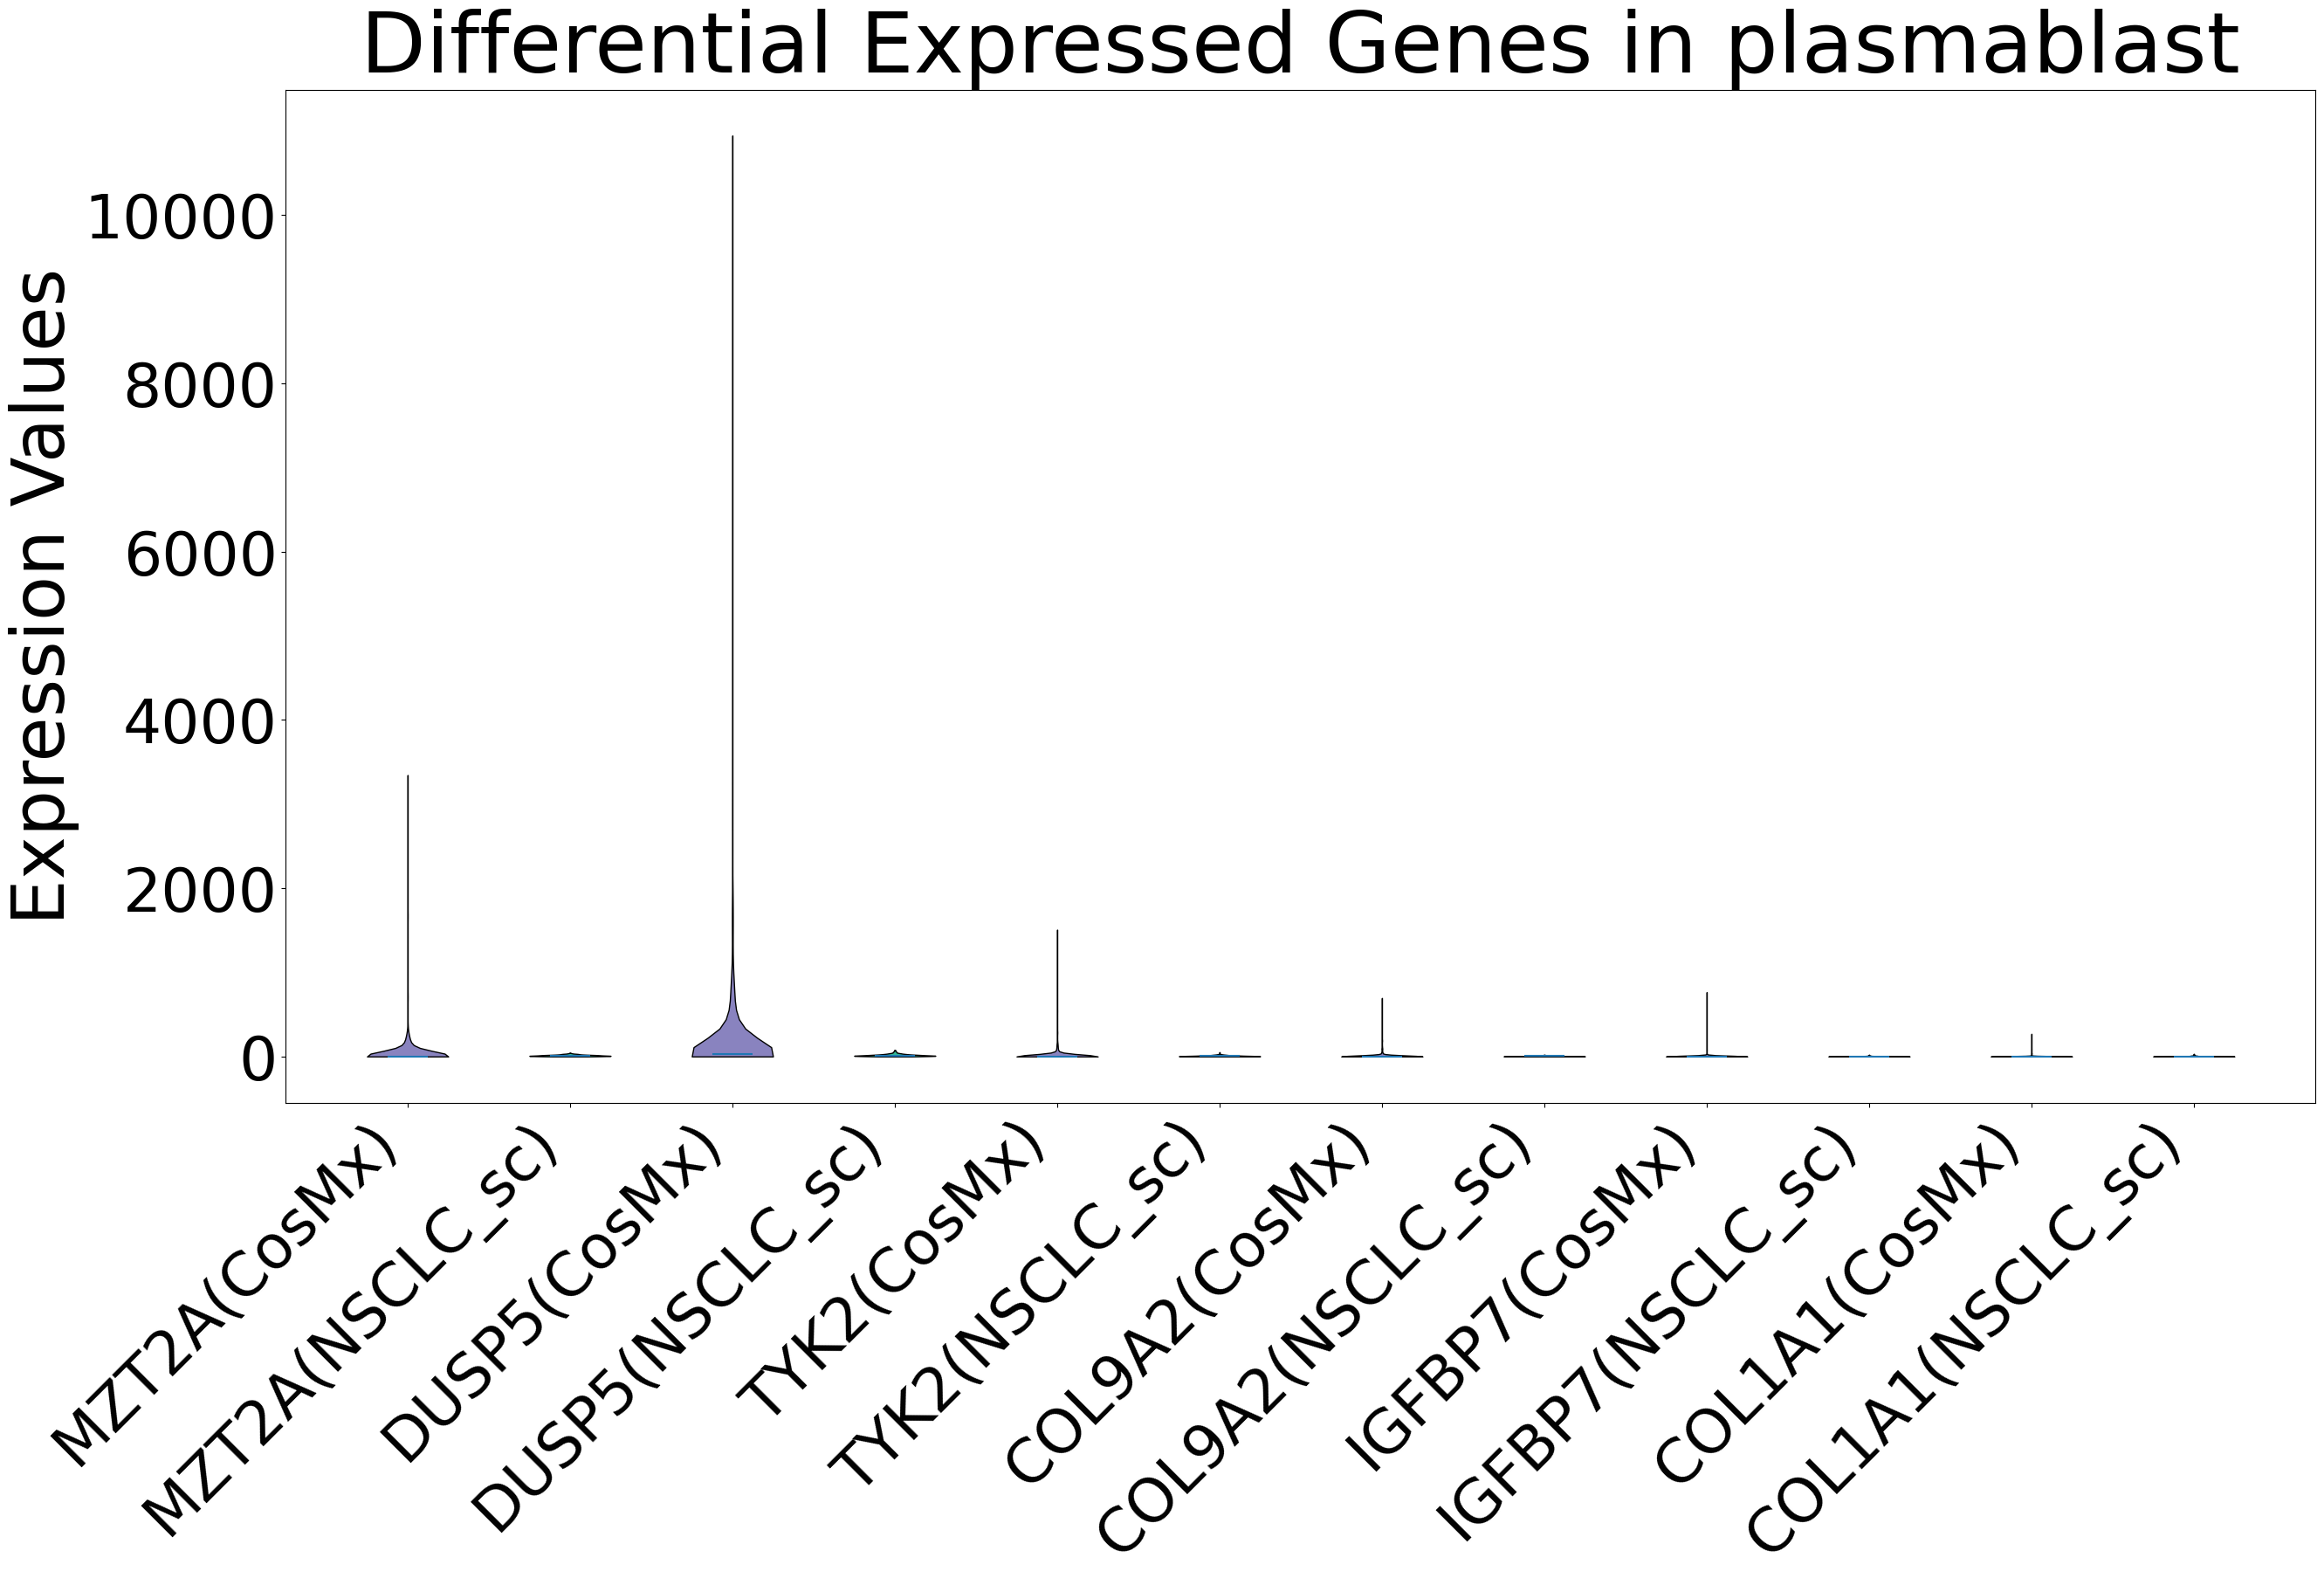

In [22]:
import matplotlib.pyplot as plt
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation = 45, fontsize = 50,  ha='right')
    ax.set_xlim(0.25, len(labels) + 0.75)
    # ax.set_ylabel('Y Axis', fontsize=14)
    # ax.set_yticks(fontsize = 10)
    ax.tick_params(axis='y', labelsize=50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 20), sharey=True)
ax.set_ylabel("Expression Values", fontsize= 60)
ax.set_title("Differential Expressed Genes in %s"%(chosen_celltype_cosmx), fontsize= 70)
parts = ax.violinplot(
    data_plotter, showmeans=False, showmedians=True,
    showextrema=False
)
for i in range(len(parts['bodies'])):
    if i % 2 == 0:
        parts['bodies'][i].set_facecolor('#8983BF') 
    else:
        parts['bodies'][i].set_facecolor('#32B897') 
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)
labels = []
for gene in DEG_up_6.index:
    labels.append(gene+str("(CosMx)"))
    labels.append(gene+str("(NSCLC_sc)"))



set_axis_style(ax, labels)
plt.subplots_adjust(bottom=0.30, wspace=0.05)
# plt.savefig("Liver_Health_Cancer_%s_up.pdf"%(selected_celltype))
plt.show()